# Guided Project: Answering Business Questions using SQL

The work presented here is part of a guided project (from Dataquest) where questions are given to be answered using data in the Chinook database. All answers and analysis are my own.

## The Chinook Database Schema

The Chinook sample database schema can be seen below (image from Dataquest).

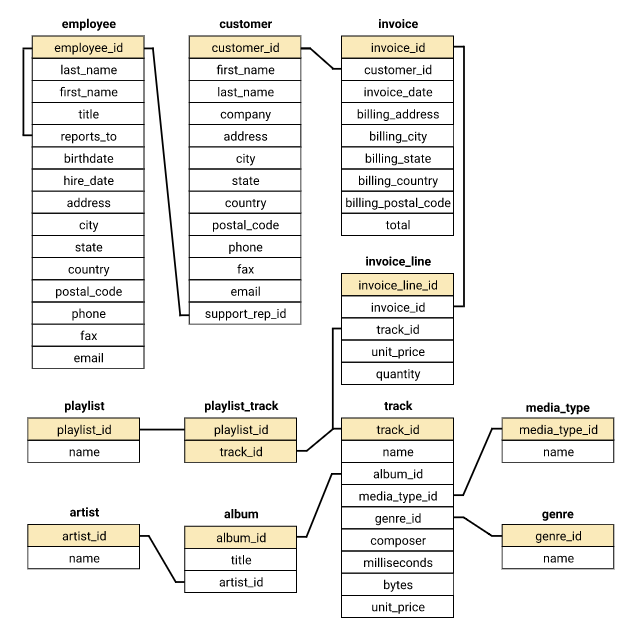

## Setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#This function takes an SQL query as an argument and returns a Pandas dataframe of that query
#The database will be queried only through this function
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

## Questions and Analysis

### Q1: Which genres sell the most tracks in the USA? Choose 3 albums to be added to the store based on this.

There are 4 new albums, 3 of which can be added to the Chinook store targeted towards an American audience. The artists do not currently have any tracks in the store. The artists and their music genres can be seen in `df_new_artists`. 

In [8]:
df_new_artists = pd.DataFrame({'Artist Name' : ['Regal', 'Red Tone',
                                  'Meteor and the Girls',
                                  'Slim Jim Bites'],
                 'Genre' : ['Hip-Hop', 'Punk',
                           'Pop', 'Blues']})

In [9]:
df_new_artists

,Artist Name,Genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


To answer this question, the percentage of tracks sold in the USA broken down by genre will first be obtained. The new albums will be selected by choosing the top 3 genres from the list seen in `df_new_artists`.

The query itself will first select data from `invoice` and `invoice_line` where the billing country is equal to the USA. This will be joined to data in the `track` table and the `genre` table. Finally, the sum of the tracks and percent per genre will be returned.

The specific query can be seen below:

In [65]:
query_usa = """
             WITH usa_id AS (
                        SELECT i.invoice_id, i.billing_country, il.track_id, il.quantity
                        FROM invoice i
                        INNER JOIN invoice_line il
                        ON i.invoice_id=il.invoice_id
                        WHERE i.billing_country='USA'
                        ),
                        
             tracks_usa AS (
                         SELECT usa.track_id, usa.quantity, g.name genre
                         FROM usa_id usa
                         LEFT join track t
                         ON usa.track_id=t.track_id
                         LEFT JOIN genre as g
                         ON t.genre_id=g.genre_id
                         )
                         
             SELECT genre, 
                    SUM(quantity) total_tracks, 
                    CAST(SUM(quantity) AS FLOAT)/ (SELECT SUM(quantity) FROM tracks_usa) * 100 percent_usa
             FROM tracks_usa
             GROUP BY genre
             ORDER BY 2 DESC
"""

In [66]:
usa_results = run_query(query_usa)
usa_results

,genre,total_tracks,percent_usa
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Pop,22,2.093245
7,Latin,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


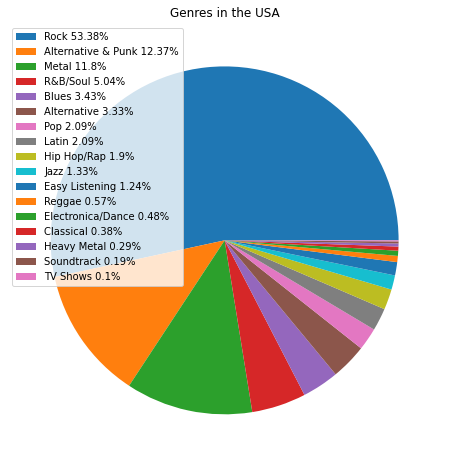

In [173]:
#Plotting results

fig, ax = plt.subplots(figsize=[8,8])

labels = usa_results['genre'].values

data = usa_results['percent_usa'].values

new_labels = []
for i in range(0, len(labels)):
    new_labels.append(labels[i] + " " + str(np.round(data[i], 2)) + "%")
    
plt.pie(x=data, pctdistance=1.1)
plt.title("Genres in the USA")
plt.legend(new_labels, loc="best")
plt.show()

From the pie chart, it appears that Rock music is the most popular genre (making up over 50% of sold tracks in the USA) although this is not one of the genres of the new albums.

To view only the 4 genres of interest, the original query was modified and ran again.

In [42]:
usa_results_four = run_query(query_usa)
usa_results_four

,genre,total_tracks,percent_usa
0,Alternative & Punk,130,12.369172
1,Blues,36,3.425309
2,Pop,22,2.093245
3,Hip Hop/Rap,20,1.902950


Based on this table, the top 3 purchased genres out of the 4 in consideration are Alternative & Punk, Blues and Pop. (Although it should be noted that there is not a large difference between Pop and Hip Hop).

The three artists whose albums should be purchased for the store should therefore be Red Tone (Punk), Slim Jim Bites (Blues) and Meteor and the Girls (Pop).

As well, if possible, the record store should consider adding more rock albums since the rock genre is significantly more popular than the 4 genres considered here.

### Q2: Analyze the purchases of customers belonging to each sales support agent.

To answer this question, the dollar amount of sales assigned to each sales support agent will be calculated. Other employee attributes will be considered as well which can possible explain any variance seen in the sales.

The query itself selects employee attributes and the invoice total by joining `employee` with `customer` and again with `invoice`. Then, the total purchases/sales are obtained for each employee. The query can be seen below:

In [3]:
query_purchase = """
                 WITH emp_totals AS
                     (
                      SELECT e.first_name || " " || e.last_name employee_name,
                          e.hire_date,
                          e.country,
                          e.state,
                          e.city,
                          i.total
                      FROM employee e
                      LEFT JOIN customer c
                          ON e.employee_id=c.support_rep_id
                      LEFT JOIN invoice i
                          ON c.customer_id=i.customer_id
                      WHERE e.title='Sales Support Agent'
                     )
                     
                 SELECT employee_name,
                        hire_date,
                        country,
                        state,
                        city,
                        SUM(total) total_purchases
                 FROM emp_totals
                 GROUP BY employee_name
                 ORDER BY total_purchases DESC

"""

In [4]:
run_query(query_purchase)

,employee_name,hire_date,country,state,city,total_purchases
0,Jane Peacock,2017-04-01 00:00:00,Canada,AB,Calgary,1731.51
1,Margaret Park,2017-05-03 00:00:00,Canada,AB,Calgary,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Canada,AB,Calgary,1393.92


From this table, we see that Jane performs the best having the largest dollar amount of sales assigned followed by Margaret and Steve. All three were hired within 6 months of each other and work in the same country, province and city. Jane was hired the earliest and is responsible for the largest total purchase amount while Steve was hired last and is responsible for the smallest total purchase amount. This suggests that the difference in sales could be attributed to the differing hiring dates and it is unclear if the total sales values is indicative of employee performance.

Examining the sales for each employee over a period of time may give a better indication of employee performance.

The previous query was modified to select the total sales for each employee per year. The modified query can be seen below:

In [5]:
query_purchase_dates = """
                 WITH emp_totals AS
                     (
                      SELECT e.first_name || " " || e.last_name employee_name,
                          i.invoice_date,
                          i.total
                      FROM employee e
                      LEFT JOIN customer c
                          ON e.employee_id=c.support_rep_id
                      LEFT JOIN invoice i
                          ON c.customer_id=i.customer_id
                      WHERE e.title='Sales Support Agent'
                     )
                     
                 SELECT employee_name,
                        strftime("%Y", invoice_date) AS year,
                        SUM(total) total_purchases
                 FROM emp_totals
                 GROUP BY employee_name, year
                 ORDER BY invoice_date

"""

In [6]:
run_query(query_purchase_dates)

,employee_name,year,total_purchases
0,Jane Peacock,2017,532.62
1,Margaret Park,2017,416.79
2,Steve Johnson,2017,252.45
3,Steve Johnson,2018,332.64
4,Jane Peacock,2018,413.82
5,Margaret Park,2018,400.95
6,Margaret Park,2019,400.95
7,Steve Johnson,2019,437.58
8,Jane Peacock,2019,383.13
9,Margaret Park,2020,365.31


In [9]:
results = run_query(query_purchase)
results_dates = run_query(query_purchase_dates)

#Plotting
x_vals = results['employee_name'].values
bar_heights = results['total_purchases'].values

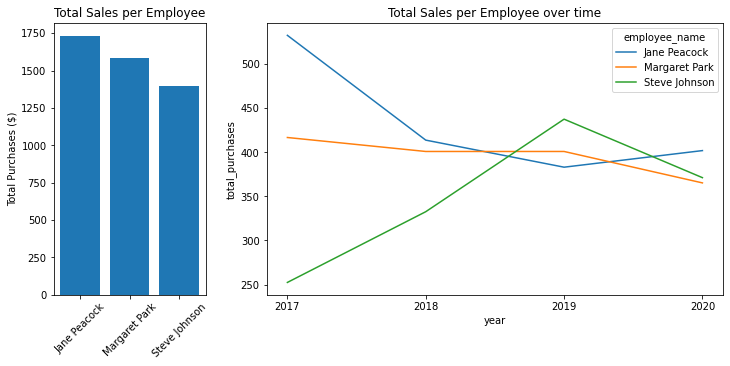

In [17]:
#subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 3]})
ax1.bar(x_vals, bar_heights)
ax1.set_xticklabels(x_vals, rotation=45)
ax1.set_ylabel("Total Purchases ($)")
ax1.set_title("Total Sales per Employee")
ax2 = sns.lineplot(x='year', y='total_purchases', hue='employee_name', data=results_dates)
ax2.set_title("Total Sales per Employee over time")
plt.show()

The left panel shows the total purchases attributed to each sales agent while the right panel shows the total purchases attributed to each agent over time between 2017 and 2020. Margaret's sales appear to be somewhat consistent year to year. Even though Steve is responsible for the lowest total dollar amount in sales, he seemed to be rapidly increasing his sales between 2017 and 2019. In addition, despite Jane having the highest total dollar amount in sales, her sales appeared to be dropping from 2017 to 2019. All three have sales within the same range in 2020 which implies that the employees are performing similarly by this year. Beyond 2020, it is possible that a pleateau in sales will be reached perhaps due to music being available on other platforms.

### Q3: Analyze sales data for customers from each country.

To answer this question, the number of customers, total sales, average sales per customer and average order value will be obtained for each country. The countries that have only 1 customer will be grouped together into a category called "Other" in order to simplify the final list of countries.

The query itself joins the `invoice` table with the `customer` table and calculates the sums and averages. The query can be seen below:

In [11]:
query_country = """

                WITH country_orders AS (
                SELECT
                       CASE WHEN (
                           COUNT(DISTINCT c.customer_id) = 1
                       ) THEN "Other"
                           ELSE c.country
                           END AS country,
                       COUNT(DISTINCT c.customer_id) customers,
                       ROUND(SUM(i.total), 2) total_sales,
                       ROUND(SUM(i.total)/COUNT(DISTINCT c.customer_id), 2) avg_sales_per_customer,
                       ROUND(SUM(i.total)/COUNT(DISTINCT i.invoice_id), 2) avg_order_value
                FROM invoice i
                LEFT JOIN customer c
                    ON c.customer_id=i.customer_id
                GROUP BY country
                )
                
                SELECT 
                    country,
                    SUM(customers) customers,
                    SUM(total_sales) total_sales,
                    ROUND(AVG(avg_sales_per_customer), 2) avg_sales_per_customer,
                    ROUND(AVG(avg_order_value), 2) avg_order_value
                FROM country_orders
                GROUP BY country
                ORDER BY customers
"""

In [12]:
country_results = run_query(query_country)
country_results

,country,customers,total_sales,avg_sales_per_customer,avg_order_value
0,Czech Republic,2,273.24,136.62,9.11
1,India,2,183.15,91.58,8.72
2,Portugal,2,185.13,92.57,6.38
3,United Kingdom,3,245.52,81.84,8.77
4,Germany,4,334.62,83.66,8.16
5,Brazil,5,427.68,85.54,7.01
6,France,5,389.07,77.81,7.78
7,Canada,8,535.59,66.95,7.05
8,USA,13,1040.49,80.04,7.94
9,Other,15,1094.94,73.00,7.44


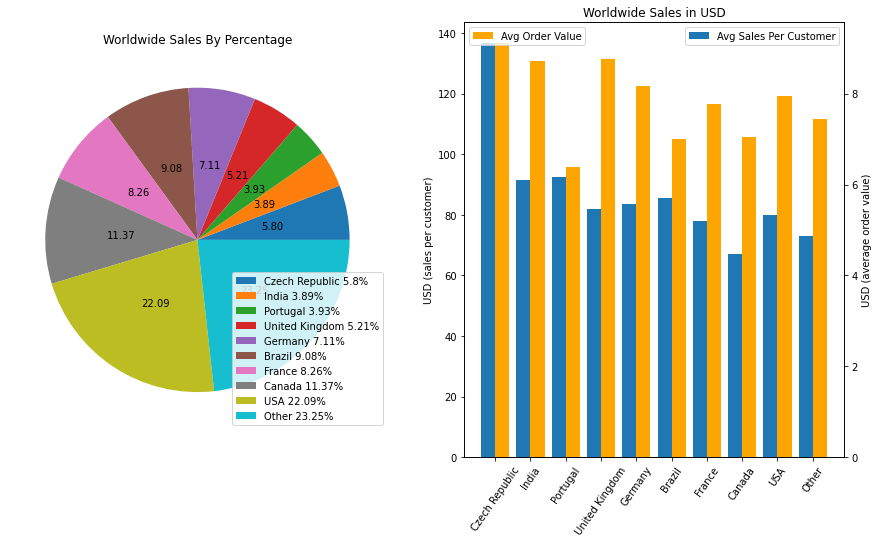

In [13]:
#Plotting

pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,8])

labels = country_results['country'].values

data = country_results['total_sales'].values

total_sales_value = sum(data)
new_labels = []
for i in range(0, len(labels)):
    new_labels.append(labels[i] + " " + str(np.round((data[i]/total_sales_value*100), 2)) + "%")

x_axis = np.arange(len(labels))

ax1.pie(x=data, autopct='%.2f', pctdistance=0.5)
ax1.set_title("Worldwide Sales By Percentage")
ax1.legend(new_labels, loc="best")

ax2.bar(x=labels, height=country_results['avg_sales_per_customer'].values, width=-0.4, align='edge', label="Avg Sales Per Customer")
ax2.set_ylabel("USD (sales per customer)")
ax3 = ax2.twinx()
ax3.bar(x=labels, height=country_results['avg_order_value'].values, width=0.4, align='edge', color='orange', label="Avg Order Value")
ax3.set_ylabel("USD (average order value)")
ax2.legend()
ax3.legend(loc="upper left")
ax2.set_xticklabels(labels, rotation=55)
ax2.set_title("Worldwide Sales in USD")
plt.show()

The left pie chart shows that the USA makes up a large percent in total worldwide sales along with the set of countries grouped as "Other" where there was only 1 customer per country. This implies that including music for an American audience will significantly increase revenue. The right panel shows that while the Czech Republic is responsible for the largest average sale value per customer, the average order value across all the countries appears to be relatively similar. This suggests that customers in the Czech Republic are ordering more. Perhaps revenue could potentially be increased by including more music that is popular in the Czech Republic as customers there appear to spend more.

### Q4: What percentage of purchases are individual tracks versus whole albums?

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

* Number of invoices
* Percentage of invoices

To answer this question, the tracks purchased on each invoice will be compared to the tracks on an album corresponding to a purchased track. If all the tracks came from the same album, then these two lists of tracks will be the same and therefore the invoice will be tagged as a `whole_album_purchase`. If the two lists of tracks are not the same, then the invoice will be tagged as a `single_track_purchase`. It is assumed that a customer cannot purchase multiple albums in an order and cannot purchase an album along with other tracks.

The first list of tracks is obtained from the `invoice_line` table where the `invoice_id` matches that in the `invoice` table. The second list of tracks is obtained from the `track` table where the `album_id` is equal to that obtained from joining the `track` and `invoice_line` tables and selecting the `album_id` where the `invoice_id` from `invoice_line` and `invoice` match. This essentially selects the `album_id` corresponding to a track on the invoice in question. (Only 1 `album_id` value is needed to check if all the tracks on the invoice comprise a full album).

The query is seen below:

In [18]:
query_purchases = """

                  WITH purchase_types AS (
                  SELECT i.invoice_id,
                  CASE WHEN (
                             (
                             SELECT il.track_id FROM invoice_line il
                             WHERE il.invoice_id=i.invoice_id
                             
                             EXCEPT
                             
                             SELECT t.track_id FROM track t
                             WHERE t.album_id = (SELECT album_id FROM track t
                                    INNER JOIN invoice_line il2
                                        ON il2.track_id = t.track_id
                                    WHERE il2.invoice_id = i.invoice_id
                                    )
                              ) IS NULL
                              
                            AND
                        
                            (
                             SELECT t.track_id FROM track t
                             WHERE t.album_id = (SELECT album_id FROM track t2
                                    INNER JOIN invoice_line il2
                                        ON il2.track_id = t2.track_id
                                    WHERE il2.invoice_id = i.invoice_id
                                    )
                            
                             EXCEPT
                                    
                             SELECT il.track_id FROM invoice_line il
                             WHERE i.invoice_id=il.invoice_id
                                    
                            ) IS NULL
                              
                            
                            ) THEN 'whole_album_purchase'
                            
                            ELSE 'single_track_purchase'
                            END AS purchase_type
                            
                    FROM invoice i
                    )
                    
                    SELECT purchase_type,
                            COUNT(invoice_id) invoices,
                            CAST(COUNT(*) as FLOAT)/ (SELECT COUNT(*) FROM purchase_types) * 100 percent
                    FROM purchase_types
                    GROUP BY purchase_type
                    ORDER BY 1

"""

In [19]:
run_query(query_purchases)

,purchase_type,invoices,percent
0,single_track_purchase,500,81.433225
1,whole_album_purchase,114,18.566775


From these results, roughly 81% of purchases are single track purchases while roughly 19% are whole album purchases. Therefore, the Chinook record store should move to purchasing individual tracks from artists rather than full albums.